# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

import cv2
import numpy as np
import glob

from PIL import Image

## Setting up network and loading weights

In [2]:
model_name = "litemono925_weights_19"

#download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("./tmp/models/", model_name, "encoder.pth")
depth_decoder_path = os.path.join("./tmp/models/", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.LiteMono()
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(3))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame0.jpg
18.95062531627268
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame1.jpg
28.211036078452473
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame2.jpg
29.83231386383681
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame3.jpg
29.960170290579732
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame4.jpg
25.477773863180786
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame5.jpg
29.864175555017585
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame6.jpg
29.902499536594757
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame7.jpg
29.831252978286074
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/frame8.jpg
29.781053408881125
/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_f

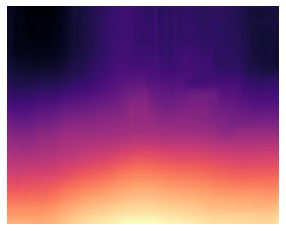

In [6]:
# imgsize /2
import time

filst = sorted(glob.glob('/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/20m_infra_1016/*.jpg'))

img_array = []
final_FPS=[]

for image_path in filst:
    start_t=time.time()
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size
    
    original_width = int(original_width/2)
    original_height = int(original_height/2)

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    feed_height = int(feed_height/2)
    feed_width = int(feed_width/2)
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    #print(input_image_pytorch)

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    #plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma')
    print(image_path)
    terminate_t=time.time()
    FPS=(1./(terminate_t-start_t))
    plt.axis('off')
    plt.savefig('image.png', transparent=True)
    
    img = cv2.imread('image.png')
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


    print(FPS)
    final_FPS.append(FPS)
print(f'mean of FPS : {sum(final_FPS)/len(img_array)}')
#out = cv2.VideoWriter('test_kitti_kaist_monovit.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
#for i in range(len(img_array)):
    #out.write(img_array[i])
#out.release()

In [ ]:
# imgsize /2
import time

filst = sorted(glob.glob('/home/yoon/Documents/s_backup/dagyeong/MonoViT/video_to_fps/100m_infra_1016/*.jpg'))

img_array = []

for image_path in filst:
    start_t=time.time()
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size
    
    original_width = int(original_width/2)
    original_height = int(original_height/2)

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    feed_height = int(feed_height/2)
    feed_width = int(feed_width/2)
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    #print(input_image_pytorch)

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    #plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma')
    print(image_path)
    terminate_t=time.time()
    FPS=(1./(terminate_t-start_t))
    plt.axis('off')
    plt.savefig('image.png', transparent=True)
    
    img = cv2.imread('image.png')
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


    print(FPS)
#out = cv2.VideoWriter('test_kitti_kaist_monovit.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
#for i in range(len(img_array)):
    #out.write(img_array[i])
#out.release()